In [13]:
!pip install toolz scikit-allel

import os
import numpy as np
import pandas as pd
import ast
import math
import re
import itertools
import random
import json
import matplotlib
from matplotlib.pyplot import plot as plt
from scipy.spatial.distance import squareform
from pylab import *
# mpl.use("pgf")
# # activate latex text rendering
# rc('text', usetex=True)
# rc('axes', linewidth=2)
# rc('font', weight='bold')
# mpl.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
#     'text.latex.preamble':r'\usepackage{sfmath} \boldmath'
# })
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import allel
sns.set_theme(style="white")


You should consider upgrading via the 'c:\users\lab\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [14]:
# load data
root_dir = './data/'
file_name = "ALL.chr22.mergedSV.v8.20130502.svs.genotypes.vcf"
new_data_header = ""
# get header
with open(root_dir + file_name, 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + file_name,
                        comment='#', sep='\t',
                        names=new_data_header.strip().split('\t'),
                        header=None)

In [15]:
geno_headers = genotypes.POS.values
positions = [int(h) for h in geno_headers]
positions[:2]


[16050654, 16533236]

In [16]:
def find_snv_chunk(s):
  s_split = s.split(";")
  for ss in s_split:
    if ss.startswith("SVTYPE"):
      return ss
  return ""


In [17]:
info = genotypes.iloc[:, 7:8]
snv_types = info.applymap(lambda x: find_snv_chunk(x).split("=")[-1]).values.flatten()
np.unique(snv_types, return_counts=True)

(array(['ALU', 'CNV', 'DEL', 'DEL_ALU', 'DUP', 'INS', 'INV', 'LINE1',
        'SVA'], dtype=object),
 array([ 96,  55, 573,   9,  79,   4,   5,   7,  20], dtype=int64))

In [18]:
genotypes = genotypes.iloc[:, 9:].T
headers = genotypes.columns[:]
genotypes

,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,843,844,845,846,847
HG00096,3|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|1,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,3|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,3|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21143,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [19]:
ped_file = 'integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(root_dir+ped_file, sep='\t', index_col='Individual ID')
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [20]:
def get_max_genotype(g):
  v1, v2 = g.split("|")
  return max(int(v1), int(v2)) + 1

def key_gen(v1, v2):
  return f"{v1}|{v2}"

genotype_keys = np.unique(genotypes.values)
max_gen = max(map(get_max_genotype, genotype_keys))
onehot_encoding_depth = max_gen**2 + 1
genotype_keys = [key_gen(i,j) for i in range(max_gen) for j in range(max_gen)]
replacement_dict = {k:i for i,k in enumerate(genotype_keys)}
reverse_replacement_dict = {v:k for k,v in replacement_dict.items()}
max_gen, onehot_encoding_depth

(6, 37)

In [21]:
Y_train = pedigree.loc[genotypes.index]['Population']
X = genotypes[genotypes.index.isin(Y_train.index)]
X = X.replace(replacement_dict)
X.shape

(2504, 848)

In [22]:
callset = allel.read_vcf(root_dir + 'ALL.chr22.mergedSV.v8.20130502.svs.genotypes.vcf')
g = allel.GenotypeArray(callset['calldata/GT'][callset['variants/CHROM'] == '22'])
gn = g.to_n_alt(fill=-1)
r = allel.rogers_huff_r(gn)
LD = squareform(r ** 2)
LD.shape

(848, 848)

In [23]:
# plt.figure(figsize=(8,8))
# sns.heatmap(LD, cmap=sns.cubehelix_palette(as_cmap=True))
#plt.show()
#

(array([553.,  97.,  81.,  19.,  98.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

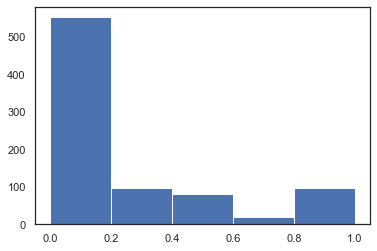

In [24]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.hist(np.max(LD, axis=1), bins=bins)

In [25]:
LD_max_freqs = np.amax(LD, axis=1)
# mean_LDs = np.mean(LD, axis=1)
# max_mean_LD = np.max(mean_LDs)
# min_mean_LD = np.min(mean_LDs)
# mean_LDs_min_max_scaled = (mean_LDs - min_mean_LD)/(max_mean_LD - min_mean_LD)
bin_labels = np.digitize(LD_max_freqs, bins=bins, right=True)
# bin_labels = np.digitize(mean_LDs_min_max_scaled, bins=bins[1:], right=True)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5], dtype=int64),
 array([553,  97,  81,  19,  98], dtype=int64))

In [27]:
columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID", "SNV type"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/SNV/SCDA/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=snv_types
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        f = np.array(snv_types[missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e,f], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df

Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:03<00:00, 234.68it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:04<00:00, 181.09it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:07<00:00, 117.31it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:02<00:00, 294.53it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:04<00:00, 190.07it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:07<00:00, 113.14it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:02<00:00, 293.45it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:04<00:00, 195.85it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:07<00:00, 116.47it/s]


Combining the results...


9it [00:00, 56.60it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID,SNV type
0,1,0.05,0.4 <= LD < 0.6,1,NA21144,DEL
1,1,0.05,0.2 <= LD < 0.4,1,NA21144,DEL
2,1,0.05,0 <= LD < 0.2,1,NA21144,DEL
3,1,0.05,0 <= LD < 0.2,1,NA21144,DEL
4,1,0.05,0 <= LD < 0.2,1,NA21144,ALU
...,...,...,...,...,...,...
738675,3,0.2,0 <= LD < 0.2,1,HG00097,DEL
738676,3,0.2,0 <= LD < 0.2,0,HG00097,ALU
738677,3,0.2,0.4 <= LD < 0.6,1,HG00097,DEL
738678,3,0.2,0 <= LD < 0.2,1,HG00097,DEL


In [28]:
df.groupby(["MissingRate", "SNV type"]).agg( {"Accuracy":["mean", "std"]})

Accuracy          
                          mean       std
MissingRate SNV type                    
0.05        ALU       0.924201  0.264686
            CNV       0.942226  0.233332
            DEL       0.961790  0.191705
            DEL_ALU   0.469649  0.499178
            DUP       0.996805  0.056436
            SVA       0.928514  0.257686
0.10        ALU       0.925040  0.263332
            CNV       0.943610  0.230682
            DEL       0.962033  0.191118
            DEL_ALU   0.484425  0.499857
            DUP       0.997304  0.051851
            LINE1     0.927716  0.259010
            SVA       0.918131  0.274192
0.20        ALU       0.925761  0.262162
            CNV       0.945215  0.227564
            DEL       0.962292  0.190490
            DEL_ALU   0.484026  0.499795
            DUP       0.997005  0.054647
            INS       0.991613  0.091212
            INV       0.990815  0.095418
            LINE1     0.928514  0.257686
            SVA       0.916534  0.276600

In [22]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.952837
     0.10         0.953650
     0.20         0.953818
2    0.05         0.954919
     0.10         0.954691
     0.20         0.954569
3    0.05         0.952895
     0.10         0.953423
     0.20         0.954366

In [23]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.05         0.953550  0.001185
0.10         0.953921  0.000676
0.20         0.954251  0.000389

In [27]:
# print(df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})
#             .to_latex(multirow=True))

In [24]:
columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/AE/preds_mixed_mr_{missing_perc}_fold_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    # result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df

Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 605.69it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 345.85it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:03<00:00, 230.03it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 525.14it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 388.78it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:03<00:00, 229.07it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:01<00:00, 543.28it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:02<00:00, 393.91it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:04<00:00, 204.46it/s]


Combining the results...


9it [00:00, 81.35it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID
0,1,0.05,0 <= LD < 0.2,1,NA21144
1,1,0.05,0.2 <= LD < 0.4,1,NA21144
2,1,0.05,0 <= LD < 0.2,1,NA21144
3,1,0.05,0 <= LD < 0.2,1,NA21144
4,1,0.05,0 <= LD < 0.2,1,NA21144
...,...,...,...,...,...
738675,3,0.2,0.2 <= LD < 0.4,1,HG00097
738676,3,0.2,0 <= LD < 0.2,1,HG00097
738677,3,0.2,0 <= LD < 0.2,1,HG00097
738678,3,0.2,0.4 <= LD < 0.6,1,HG00097


In [25]:
df.to_csv("results_in_table/Chr22/ALL/LD_AE.csv")

In [26]:
df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]})

Accuracy          
                                 mean       std
MissingRate LD                                 
0.05        0 <= LD < 0.2    0.933795  0.248642
            0.2 <= LD < 0.4  0.965655  0.182121
            0.4 <= LD < 0.6  0.996905  0.055550
            0.6 <= LD < 0.8  0.994409  0.074579
            0.8 <= LD <= 1   0.987859  0.109518
0.10        0 <= LD < 0.2    0.935870  0.244985
            0.2 <= LD < 0.4  0.963037  0.188675
            0.4 <= LD < 0.6  0.997304  0.051851
            0.6 <= LD < 0.8  0.993411  0.080916
            0.8 <= LD <= 1   0.980112  0.139619
0.20        0 <= LD < 0.2    0.937006  0.242952
            0.2 <= LD < 0.4  0.964940  0.183933
            0.4 <= LD < 0.6  0.996905  0.055548
            0.6 <= LD < 0.8  0.992612  0.085641
            0.8 <= LD <= 1   0.986482  0.115481

In [27]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.950271
     0.10         0.950941
     0.20         0.953180
2    0.05         0.953065
     0.10         0.950299
     0.20         0.953109
3    0.05         0.951096
     0.10         0.952567
     0.20         0.952677

In [28]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.05         0.951477  0.001436
0.10         0.951269  0.001169
0.20         0.952989  0.000272

In [29]:
# print(df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})
#             .to_latex(multirow=True))

In [49]:
columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/HLA_DEEP/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df

Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 614.22it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 414.70it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:03<00:00, 235.77it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 583.82it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 394.81it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:03<00:00, 231.19it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:01<00:00, 618.46it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:01<00:00, 422.89it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:03<00:00, 225.77it/s]


Combining the results...


9it [00:00, 81.63it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID
0,1,0.05,0 <= LD < 0.2,1,NA21144
1,1,0.05,0.2 <= LD < 0.4,1,NA21144
2,1,0.05,0 <= LD < 0.2,1,NA21144
3,1,0.05,0 <= LD < 0.2,1,NA21144
4,1,0.05,0 <= LD < 0.2,1,NA21144
...,...,...,...,...,...
738675,3,0.2,0.2 <= LD < 0.4,1,HG00097
738676,3,0.2,0 <= LD < 0.2,1,HG00097
738677,3,0.2,0 <= LD < 0.2,1,HG00097
738678,3,0.2,0.4 <= LD < 0.6,1,HG00097


In [50]:
df.to_csv("results_in_table/Chr22/ALL/LD_HLA_DEEP.csv")

In [51]:
df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]})

Accuracy          
                                 mean       std
MissingRate LD                                 
0.05        0 <= LD < 0.2    0.937700  0.241702
            0.2 <= LD < 0.4  0.973642  0.160203
            0.4 <= LD < 0.6  0.998303  0.041165
            0.6 <= LD < 0.8  0.994808  0.071880
            0.8 <= LD <= 1   0.986422  0.115737
0.10        0 <= LD < 0.2    0.938419  0.240395
            0.2 <= LD < 0.4  0.973110  0.161766
            0.4 <= LD < 0.6  0.998053  0.044082
            0.6 <= LD < 0.8  0.994609  0.073235
            0.8 <= LD <= 1   0.986222  0.116570
0.20        0 <= LD < 0.2    0.938331  0.240553
            0.2 <= LD < 0.4  0.972087  0.164726
            0.4 <= LD < 0.6  0.997804  0.046816
            0.6 <= LD < 0.8  0.993011  0.083311
            0.8 <= LD <= 1   0.986562  0.115144

In [52]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.953094
     0.10         0.953921
     0.20         0.953747
2    0.05         0.956573
     0.10         0.955845
     0.20         0.955271
3    0.05         0.955065
     0.10         0.954765
     0.20         0.955259

In [53]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.05         0.954910  0.001744
0.10         0.954844  0.000965
0.20         0.954759  0.000876

In [21]:
# print(df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})
#             .to_latex(multirow=True))

In [35]:

columns = ["Fold", "MissingRate", "LD", "Accuracy", "Sample ID"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/Chr22/ALL/STI/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace(replacement_dict)
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df["LD"] = df["LD"].replace({
    1.0: '0 <= LD < 0.2',
    2.0: '0.2 <= LD < 0.4',
    3.0: '0.4 <= LD < 0.6',
    4.0: '0.6 <= LD < 0.8',
    5.0: '0.8 <= LD <= 1',
})
df

Fold: 1
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 591.50it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 368.78it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:03<00:00, 222.49it/s]


Fold: 2
Missing rate: 0.05


100%|██████████| 835/835 [00:01<00:00, 630.53it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:02<00:00, 407.72it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:03<00:00, 235.69it/s]


Fold: 3
Missing rate: 0.05


100%|██████████| 834/834 [00:01<00:00, 605.31it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:02<00:00, 388.29it/s]


Missing rate: 0.2


100%|██████████| 834/834 [00:03<00:00, 227.41it/s]


Combining the results...


9it [00:00, 81.06it/s]


,Fold,MissingRate,LD,Accuracy,Sample ID
0,1,0.05,0 <= LD < 0.2,1,NA21144
1,1,0.05,0.2 <= LD < 0.4,1,NA21144
2,1,0.05,0 <= LD < 0.2,1,NA21144
3,1,0.05,0 <= LD < 0.2,1,NA21144
4,1,0.05,0 <= LD < 0.2,1,NA21144
...,...,...,...,...,...
738675,3,0.2,0.2 <= LD < 0.4,1,HG00097
738676,3,0.2,0 <= LD < 0.2,1,HG00097
738677,3,0.2,0 <= LD < 0.2,1,HG00097
738678,3,0.2,0.4 <= LD < 0.6,1,HG00097


In [36]:
df.to_csv("results_in_table/Chr22/ALL/LD_STI.csv")

In [37]:
df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]})


Accuracy          
                                 mean       std
MissingRate LD                                 
0.05        0 <= LD < 0.2    0.937300  0.242424
            0.2 <= LD < 0.4  0.969169  0.172866
            0.4 <= LD < 0.6  0.997903  0.045743
            0.6 <= LD < 0.8  0.994808  0.071880
            0.8 <= LD <= 1   0.984265  0.124453
0.10        0 <= LD < 0.2    0.938535  0.240183
            0.2 <= LD < 0.4  0.970092  0.170336
            0.4 <= LD < 0.6  0.997804  0.046816
            0.6 <= LD < 0.8  0.994808  0.071873
            0.8 <= LD <= 1   0.984265  0.124450
0.20        0 <= LD < 0.2    0.939032  0.239272
            0.2 <= LD < 0.4  0.970300  0.169760
            0.4 <= LD < 0.6  0.997554  0.049398
            0.6 <= LD < 0.8  0.992911  0.083899
            0.8 <= LD <= 1   0.987041  0.113100

In [38]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.05         0.955232
     0.10         0.956601
     0.20         0.956567
2    0.05         0.950214
     0.10         0.950114
     0.20         0.951741
3    0.05         0.956035
     0.10         0.956321
     0.20         0.956827

In [39]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.05         0.953827  0.003155
0.10         0.954345  0.003667
0.20         0.955045  0.002864

In [ ]:
print(df.groupby(["MissingRate", "LD"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})
            .to_latex(multirow=True))



